https://towardsdatascience.com/hands-on-big-data-streaming-apache-spark-at-scale-fd89c15fa6b0

In [1]:

from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
sc = SparkContext()
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [3]:
socket_stream = ssc.socketTextStream("127.0.0.1", 9998)
lines = socket_stream.window( 20 )

In [4]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple('tweets', fields )

In [5]:
# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).createOrReplaceTempView("tweets") ) ) # Registers to a table.

In [6]:
ssc.start()

In [8]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# Only works for Jupyter Notebooks!
%matplotlib inline

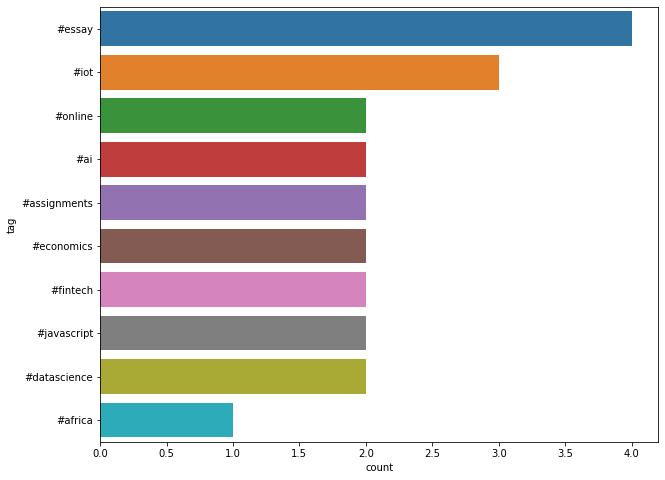

10


In [9]:
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    #top_10_df.sort(desc("count"))
    #print(top_10_df)
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1
    print (count)

In [10]:
ssc.stop()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
#streaming from textfile

input_path = '/home/hadoop/csv_data'  # csv data files are stored in csv_data directory 
#sc = SparkContext()
spark = SparkSession.builder.appName("csvtest").getOrCreate()

 

userSchema = StructType().add("name", "string").add("salary", "integer")

dfcsv = spark.readStream.option("sep", ",").option("header", "false").schema(userSchema).csv(input_path)

#ds = ssc.textFileStream(input_path)

In [2]:
dfcsv.createOrReplaceTempView("salary")
totalSalary = spark.sql("select name,sum(salary) from salary group by name")

#or
totalSalary2 = dfcsv.groupBy("name").sum("salary")

In [3]:
totalSalary

DataFrame[name: string, sum(salary): bigint]

In [4]:
totalSalary2

DataFrame[name: string, sum(salary): bigint]

In [5]:
query = totalSalary.writeStream.outputMode("complete").format("console").start()


In [ ]:
query.awaitTermination()